In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

In [3]:
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

In [4]:
import plotly.express as px

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [6]:
df = pd.read_csv("Data/heart.csv")

In [7]:
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [8]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [10]:
df.describe().T.style.background_gradient(cmap='Greens')

In [11]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

##### No null values present

## Exploratory Data Analysis

In [12]:

categorical_features = []
numerical_features = []

for col in df.columns:
    if col == "HeartDisease":
        continue  # do not treat target as a feature

    if df[col].nunique() > 6:
        numerical_features.append(col)
    else:
        categorical_features.append(col)

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)


Categorical Features: ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Numerical Features: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']


In [13]:
encoder = LabelEncoder()
df_encoded = df.copy()
cols_to_encode = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for col in cols_to_encode:
    df_encoded[col] = encoder.fit_transform(df_encoded[col])


In [14]:
df.HeartDisease.value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

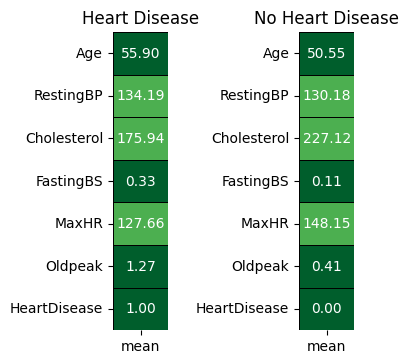

In [15]:
yes = df[df['HeartDisease'] == 1].describe().T
no  = df[df['HeartDisease'] == 0].describe().T

colors = ['#005E2C', '#4CAF50']

fig, ax = plt.subplots(1, 2, figsize=(4, 4))

sns.heatmap(
    yes[['mean']],
    annot=True,
    cmap=colors,
    linewidths=0.4,
    linecolor='black',
    cbar=False,
    fmt='.2f',
    ax=ax[0]
)
ax[0].set_title("Heart Disease")

sns.heatmap(
    no[['mean']],
    annot=True,
    cmap=colors,
    linewidths=0.4,
    linecolor='black',
    cbar=False,
    fmt='.2f',
    ax=ax[1]
)
ax[1].set_title("No Heart Disease")

plt.tight_layout(pad=2)
plt.show()


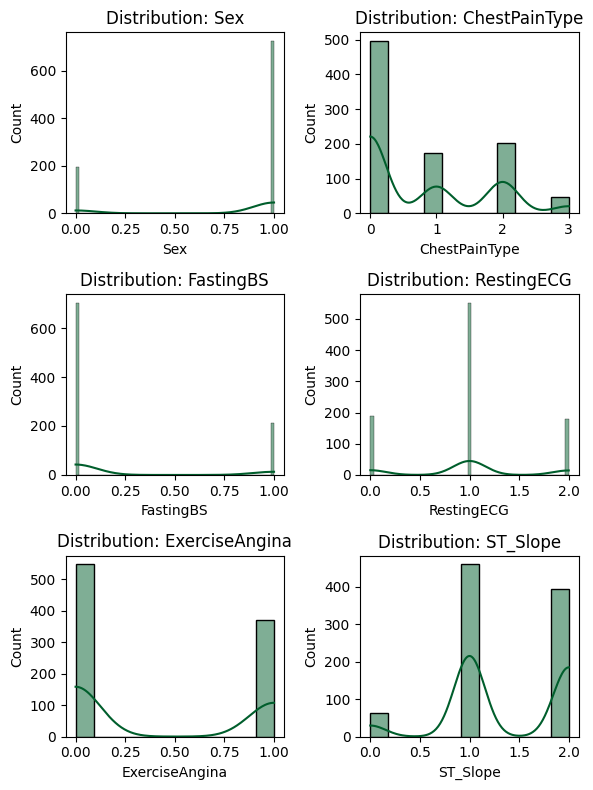

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(6, 8))
for a, f in zip(ax.flatten(), categorical_features):
    sns.histplot(df_encoded[f], kde=True, kde_kws={'bw_adjust':1}, color=colors[0], ax=a)
    a.set_title(f"Distribution: {f}")
plt.tight_layout()

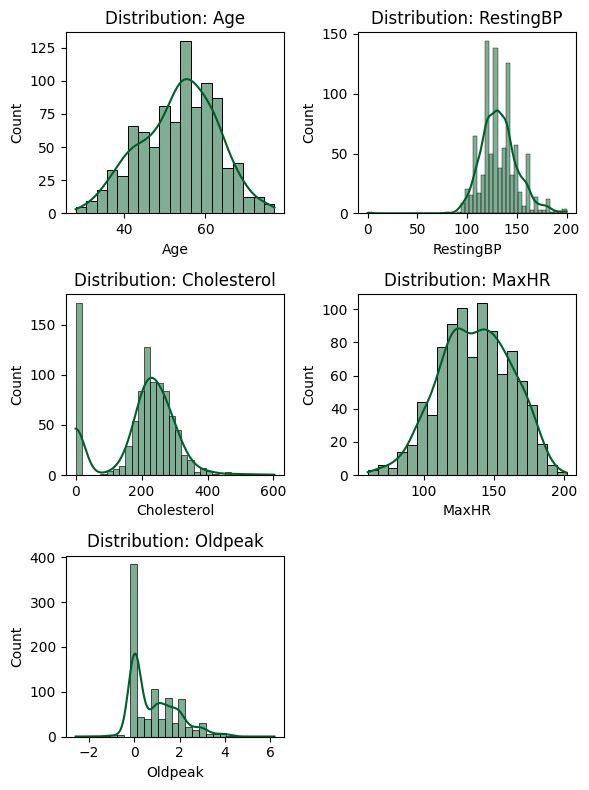

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(6, 8))
axs = ax.flatten()
for a, f in zip(ax.flatten(), numerical_features):
    sns.histplot(df[f], kde=True, kde_kws={'bw_adjust':1}, color=colors[0], ax=a)
    a.set_title(f"Distribution: {f}")
for j in range(len(numerical_features), len(axs)):
    fig.delaxes(axs[j])
plt.tight_layout()

([<matplotlib.patches.Wedge at 0x7c9449d90b60>,
 [Text(-0.2002845025766636, 1.1831678317244847, 'No Heart Disease'),
  Text(0.18359448075986173, -1.0845704525914934, 'Heart Disease')],
 [Text(-0.11683262650305377, 0.6901812351726161, '55.3%'),
  Text(0.10014244405083365, -0.5915838832317236, '44.7%')])

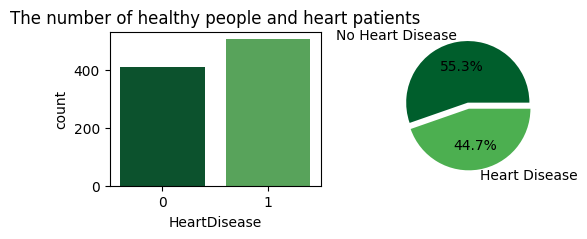

In [18]:
vals = df['HeartDisease'].value_counts()
plt.figure(figsize=(6,2))

plt.subplot(1,2,1)
sns.countplot(df, x ='HeartDisease', palette=colors)
plt.title('The number of healthy people and heart patients')

plt.subplot(1,2,2)
plt.pie(vals, labels=['No Heart Disease','Heart Disease'], colors=colors, explode = (0.1, 0), autopct='%1.1f%%')

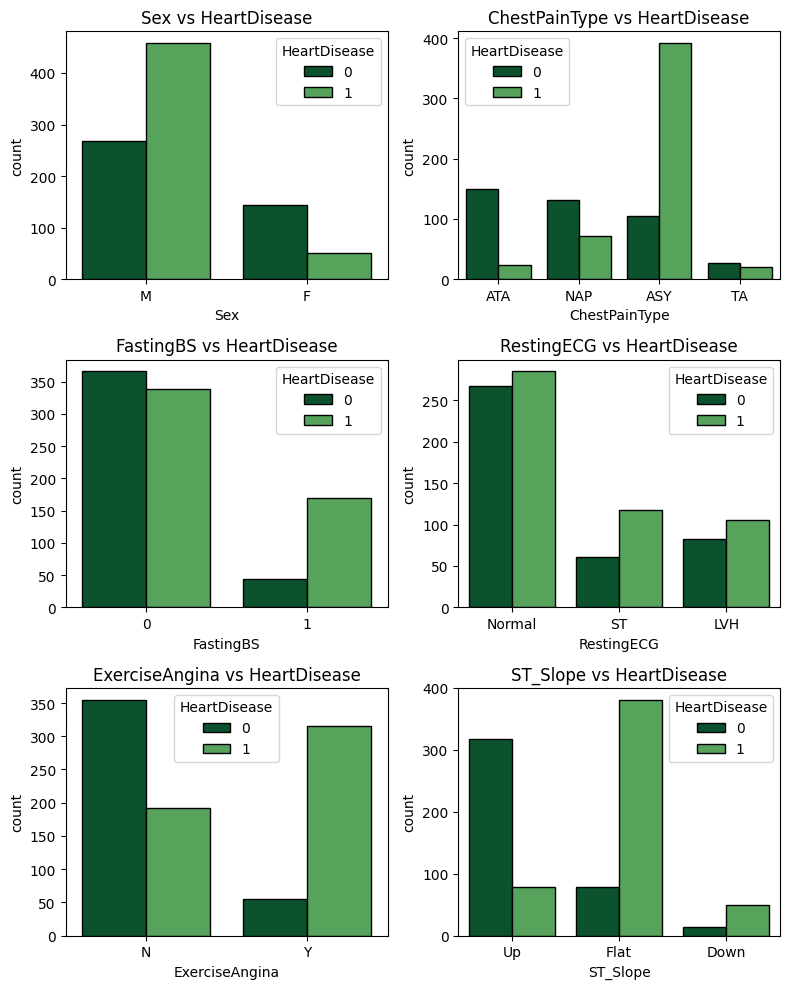

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(8, 10))

for a, f in zip(ax.flatten(), categorical_features):
    sns.countplot(x=f, data=df, hue="HeartDisease",
                  palette=colors, edgecolor='black', ax=a)
    a.set_title(f"{f} vs HeartDisease")

# remove empty subplots
for a in ax.flatten()[len(categorical_features):]:
    fig.delaxes(a)

plt.tight_layout()
plt.show()



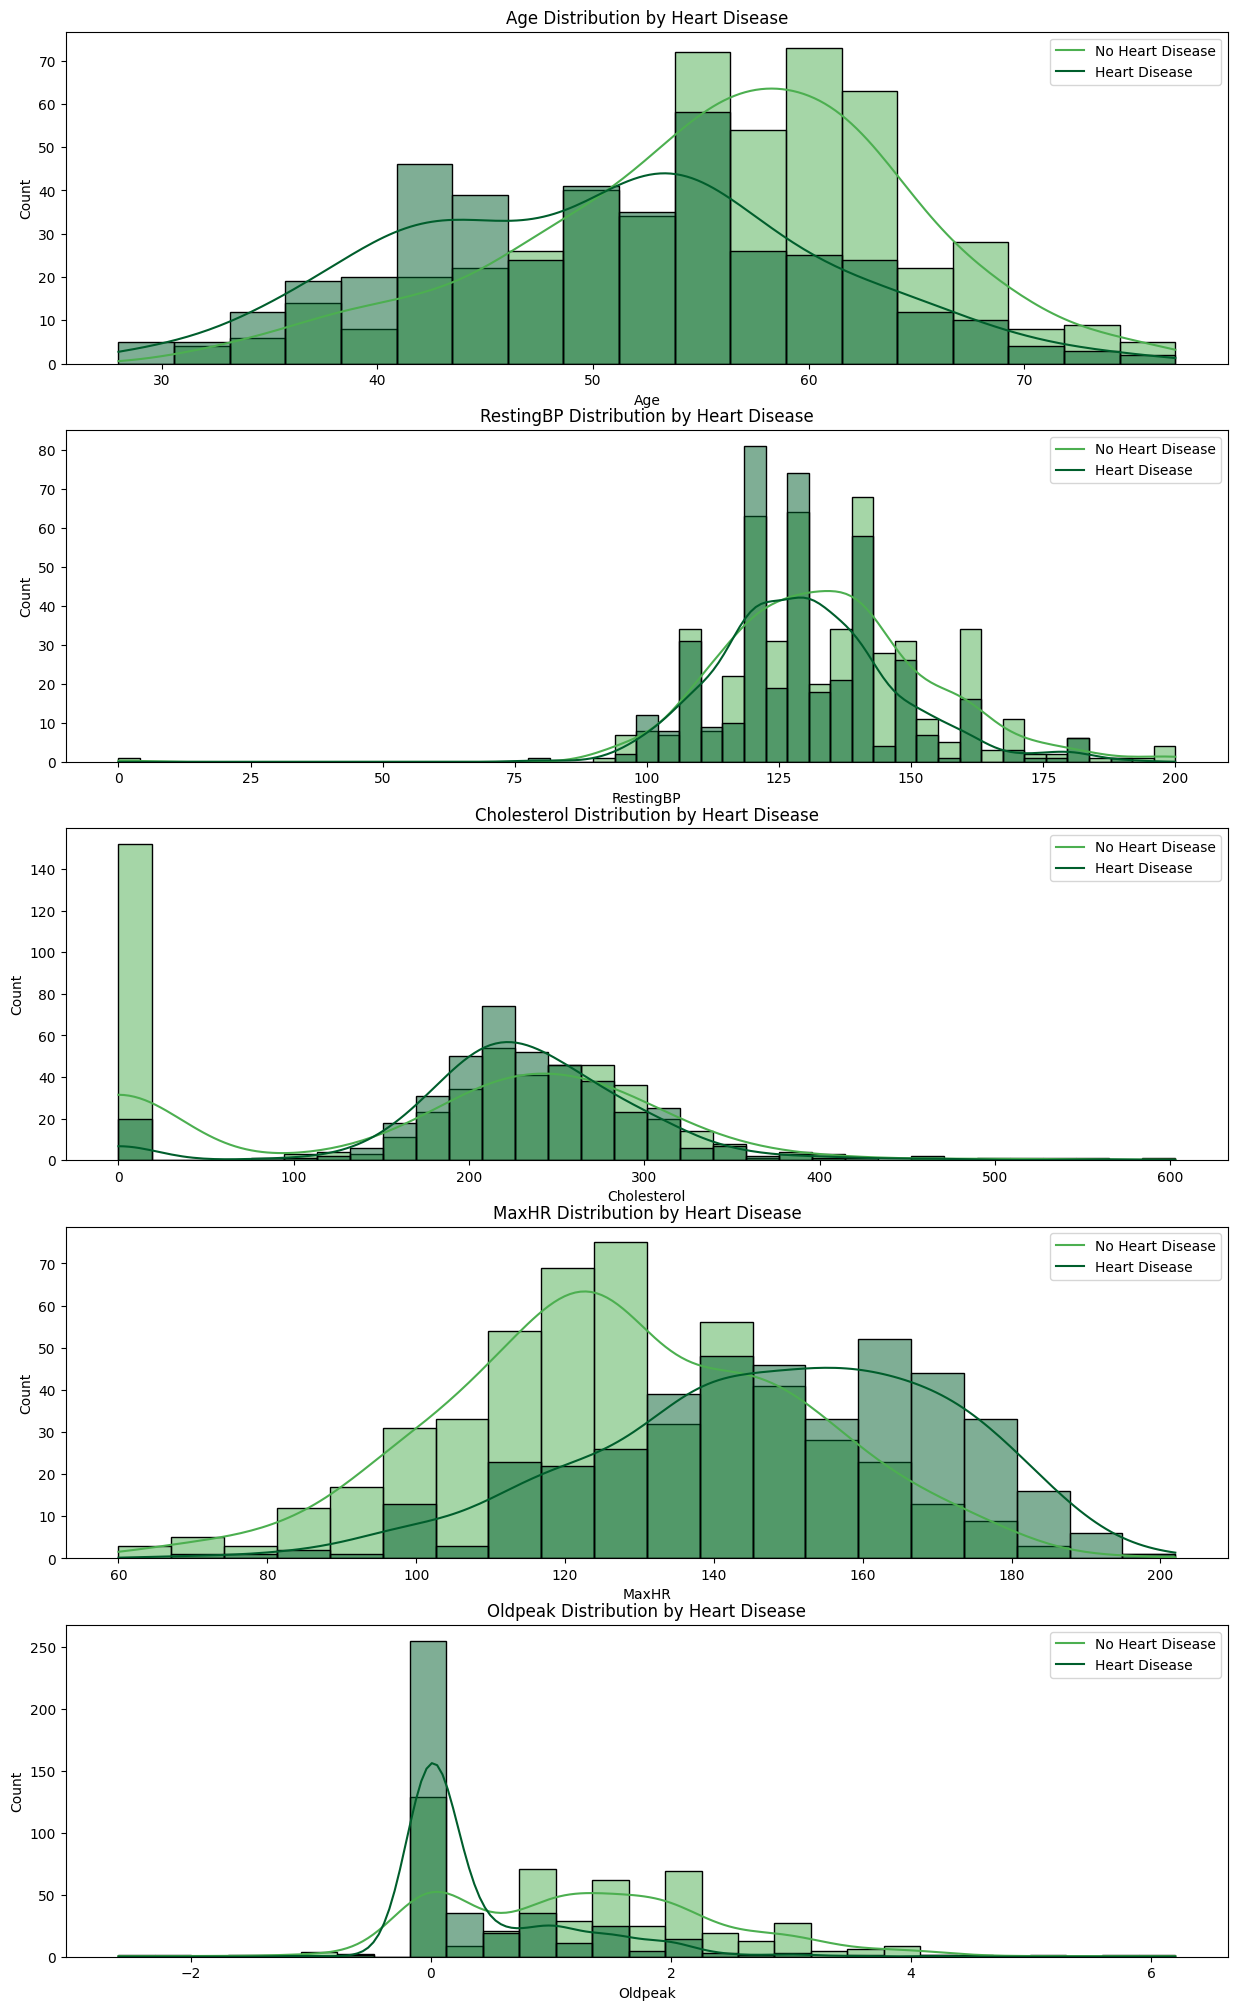

In [20]:
fig, ax = plt.subplots(nrows = 5,ncols = 1,figsize = (15,25))
for i in range(len(numerical_features)):
    plt.subplot(5,1,i+1)
    sns.histplot(data=df, x=numerical_features[i], hue="HeartDisease", palette=colors, kde = True, edgecolor = 'black')
    plt.legend(['No Heart Disease','Heart Disease'])
    plt.title(f'{numerical_features[i]} Distribution by Heart Disease');

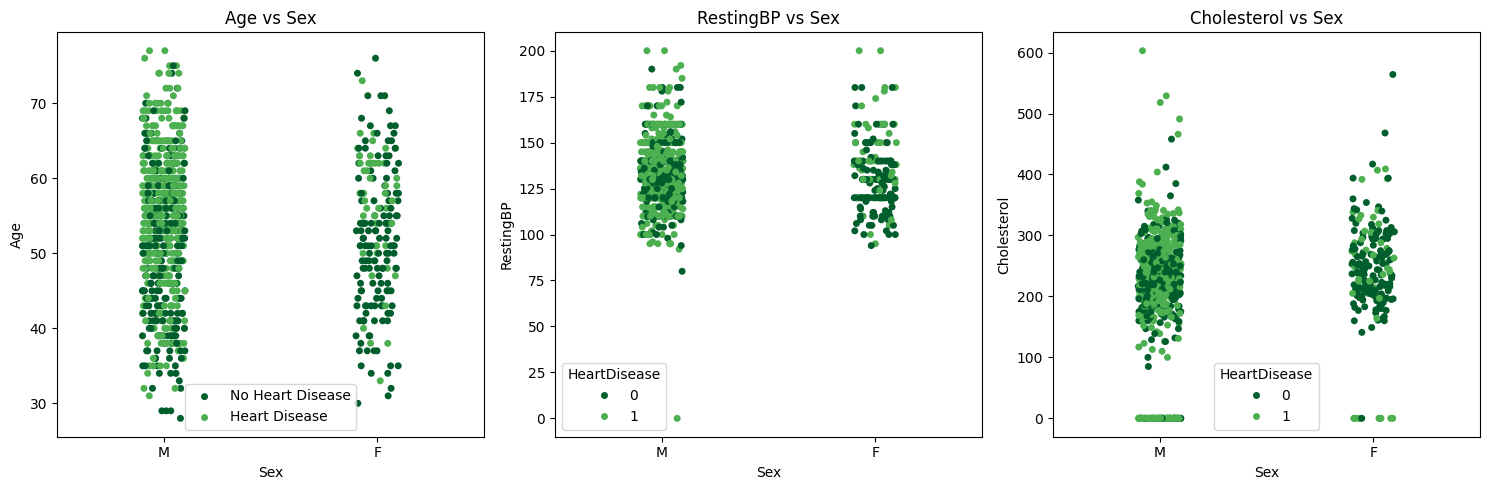

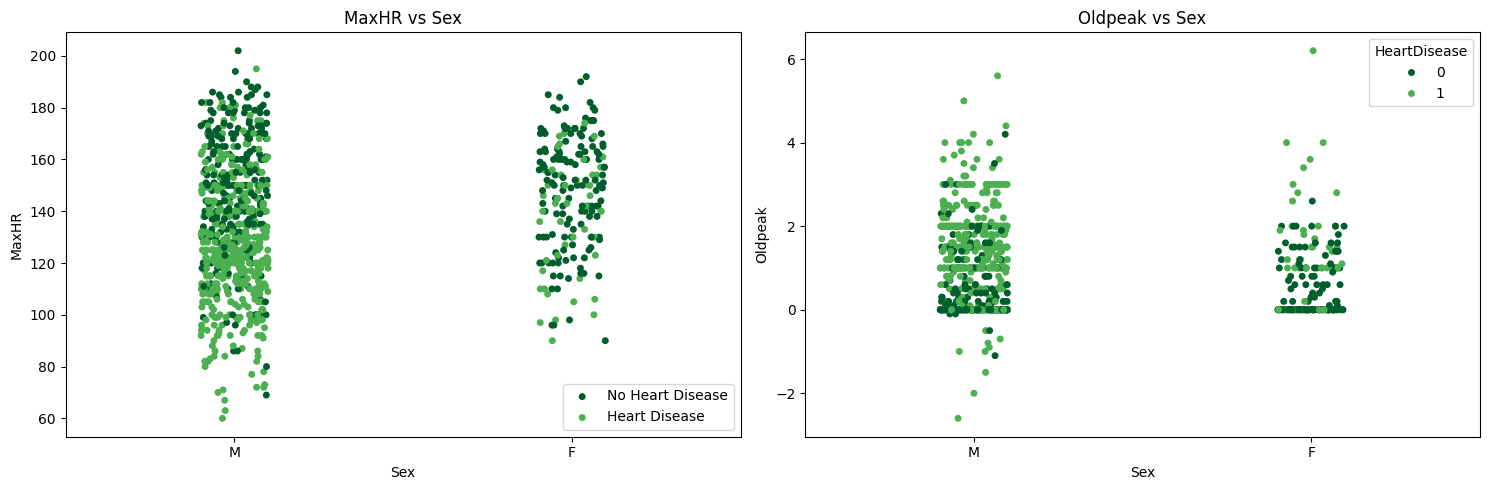

In [21]:
# First 3 numerical features
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for a, f in zip(ax, numerical_features[:3]):
    sns.stripplot(x='Sex', y=f, data=df, hue='HeartDisease',
                  palette=colors, ax=a)
    a.set_title(f"{f} vs Sex")
# remove duplicate legends for subplots
ax[0].legend(['No Heart Disease', 'Heart Disease'])
plt.tight_layout()
plt.show()


# Last 2 numerical features
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for a, f in zip(ax, numerical_features[-2:]):
    sns.stripplot(x='Sex', y=f, data=df, hue='HeartDisease',
                  palette=colors, ax=a)
    a.set_title(f"{f} vs Sex")

ax[0].legend(['No Heart Disease', 'Heart Disease'])

plt.tight_layout()
plt.show()

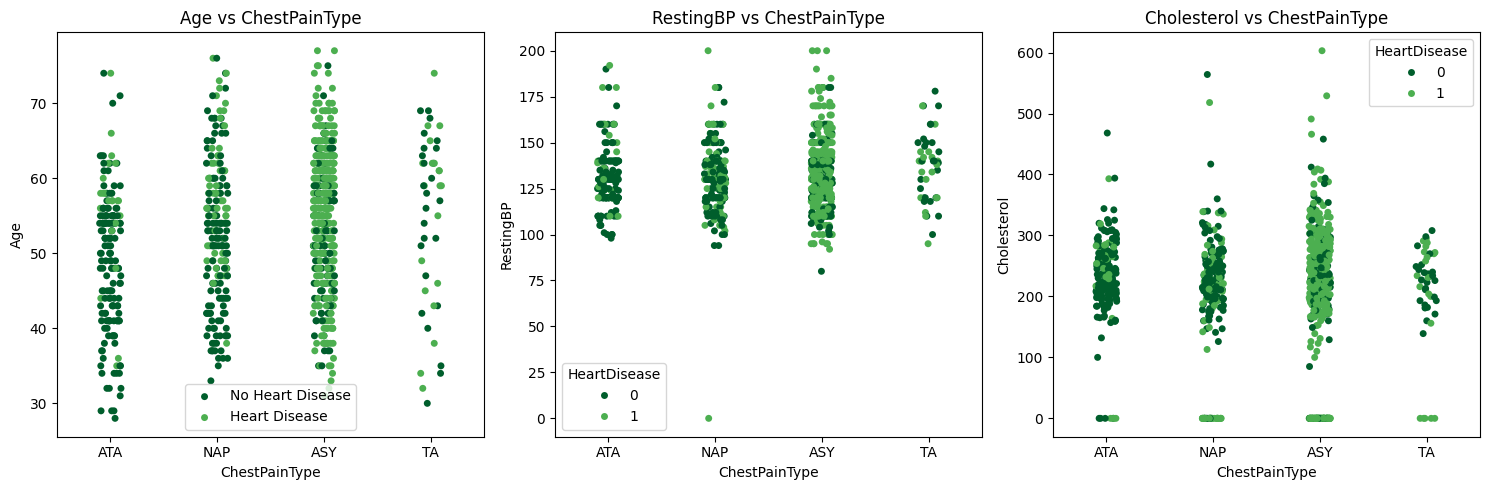

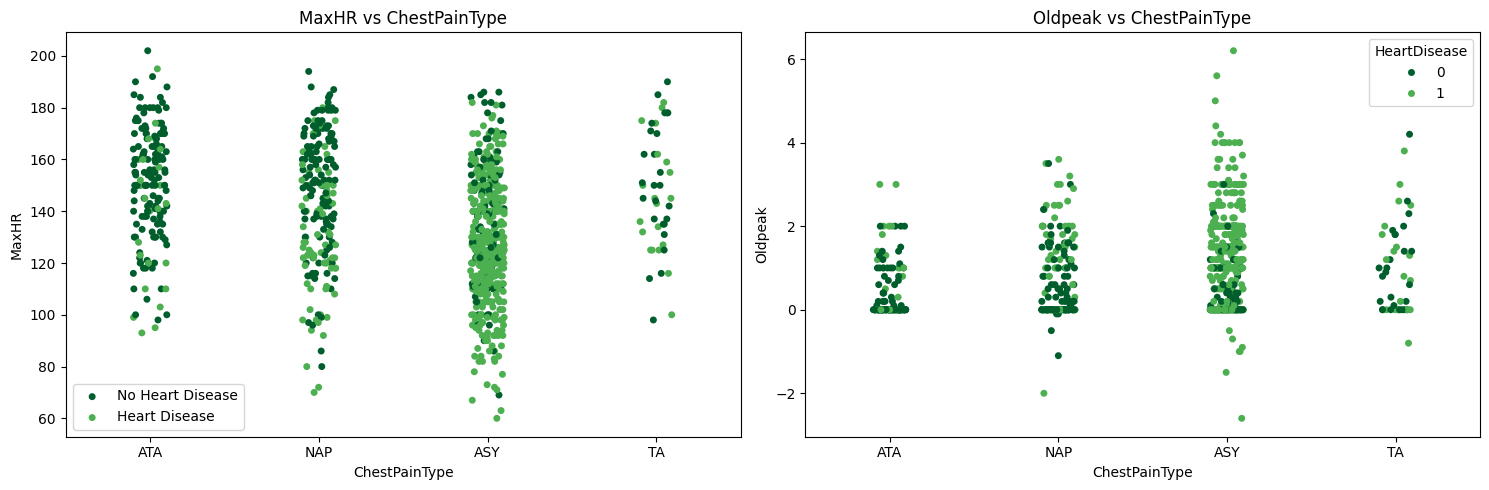

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for a, f in zip(ax, numerical_features[:3]):
    sns.stripplot(x='ChestPainType', y=f, data=df,
                  hue='HeartDisease', palette=colors, ax=a)
    a.set_title(f"{f} vs ChestPainType")

ax[0].legend(['No Heart Disease', 'Heart Disease'])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for a, f in zip(ax, numerical_features[-2:]):
    sns.stripplot(x='ChestPainType', y=f, data=df,
                  hue='HeartDisease', palette=colors, ax=a)
    a.set_title(f"{f} vs ChestPainType")

ax[0].legend(['No Heart Disease', 'Heart Disease'])
plt.tight_layout()
plt.show()

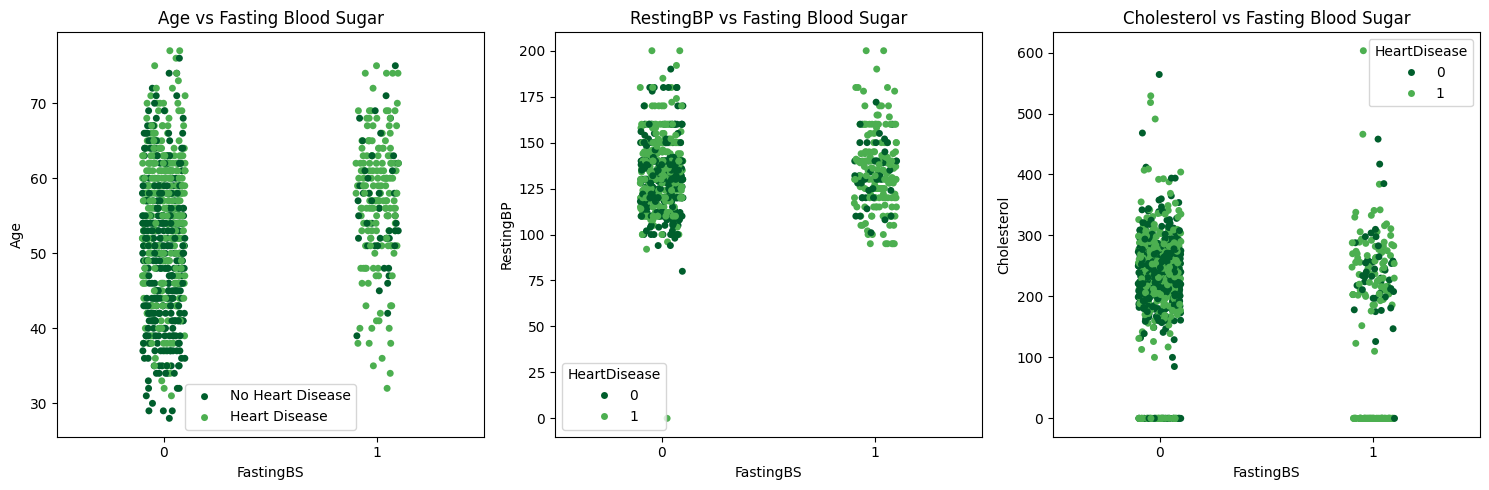

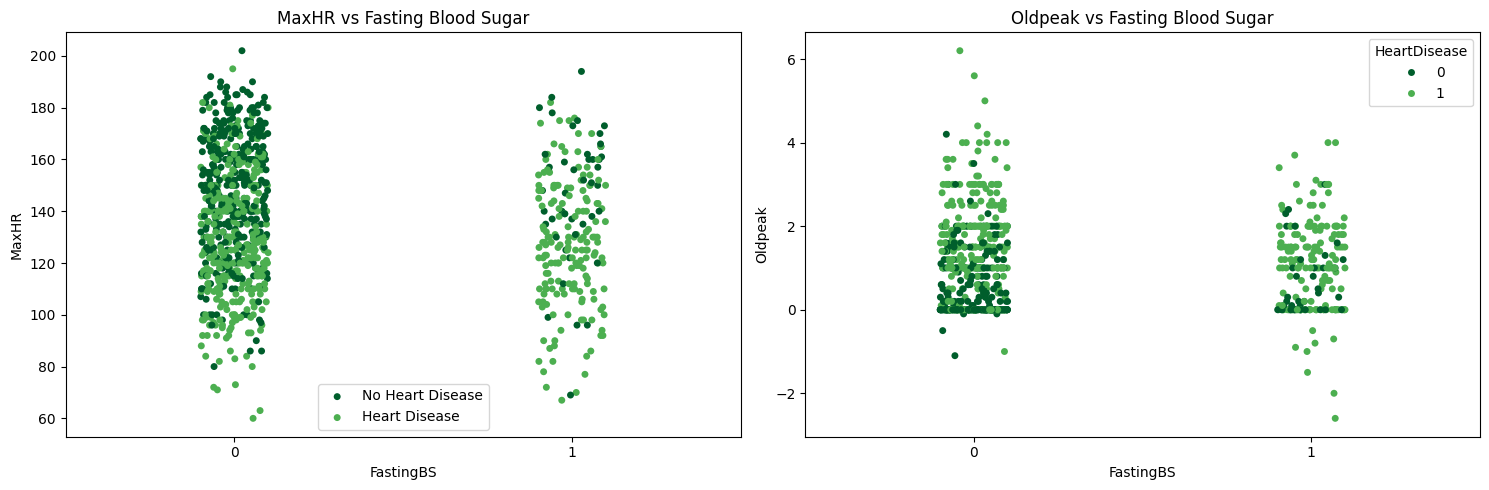

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for a, f in zip(ax, numerical_features[:3]):
    sns.stripplot(x='FastingBS', y=f, data=df,
                  hue='HeartDisease', palette=colors, ax=a)
    a.set_title(f"{f} vs Fasting Blood Sugar")

ax[0].legend(['No Heart Disease', 'Heart Disease'])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for a, f in zip(ax, numerical_features[-2:]):
    sns.stripplot(x='FastingBS', y=f, data=df,
                  hue='HeartDisease', palette=colors, ax=a)
    a.set_title(f"{f} vs Fasting Blood Sugar")

ax[0].legend(['No Heart Disease', 'Heart Disease'])
plt.tight_layout()
plt.show()


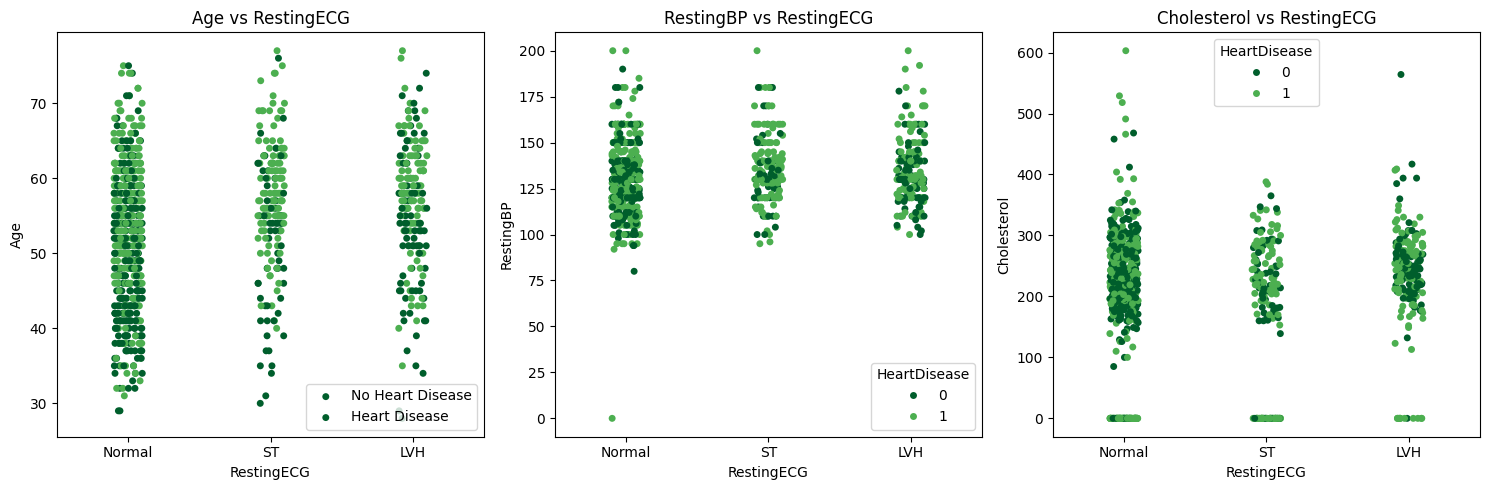

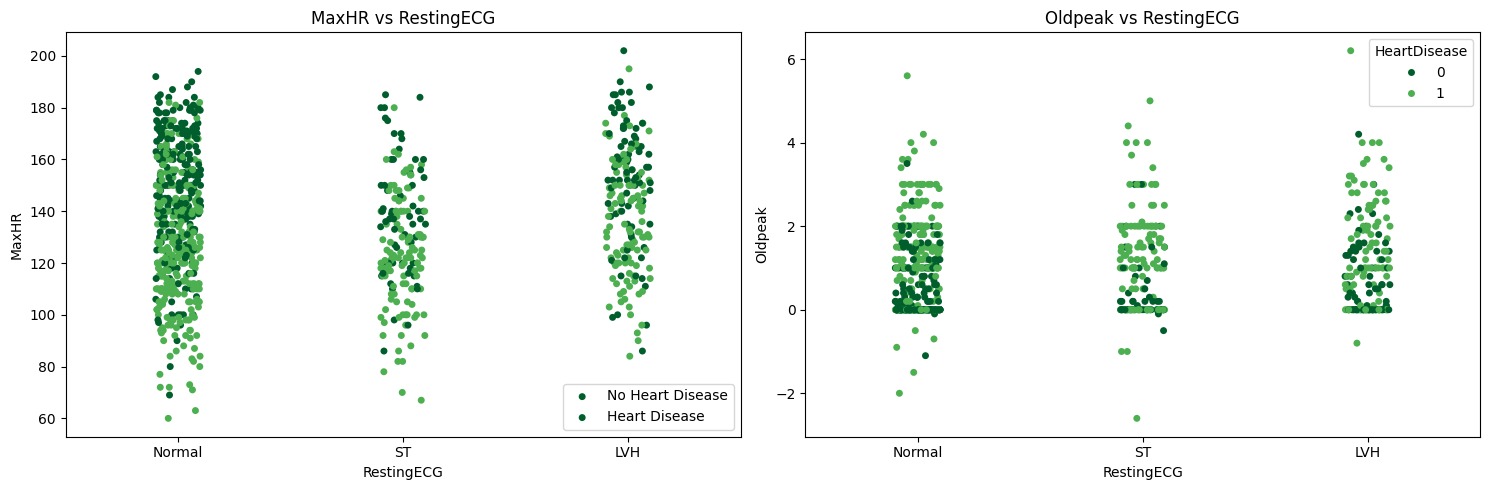

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for a, f in zip(ax, numerical_features[:3]):
    sns.stripplot(x='RestingECG', y=f, data=df,
                  hue='HeartDisease', palette=colors, ax=a)
    a.set_title(f"{f} vs RestingECG")

ax[0].legend(['No Heart Disease', 'Heart Disease'])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for a, f in zip(ax, numerical_features[-2:]):
    sns.stripplot(x='RestingECG', y=f, data=df,
                  hue='HeartDisease', palette=colors, ax=a)
    a.set_title(f"{f} vs RestingECG")

ax[0].legend(['No Heart Disease', 'Heart Disease'])
plt.tight_layout()
plt.show()


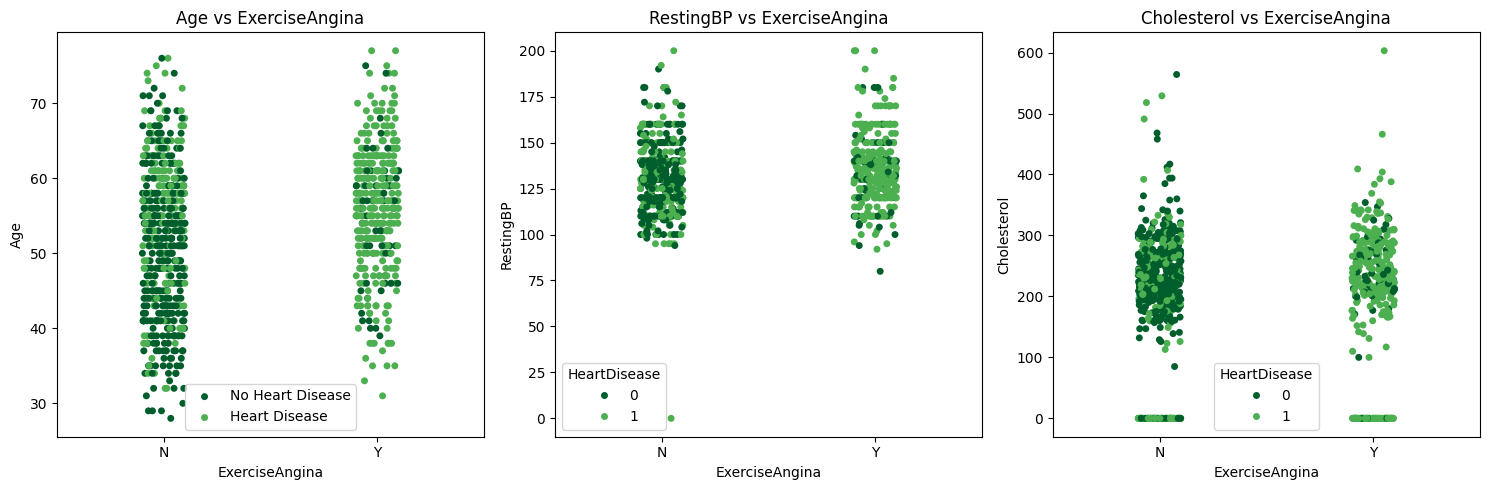

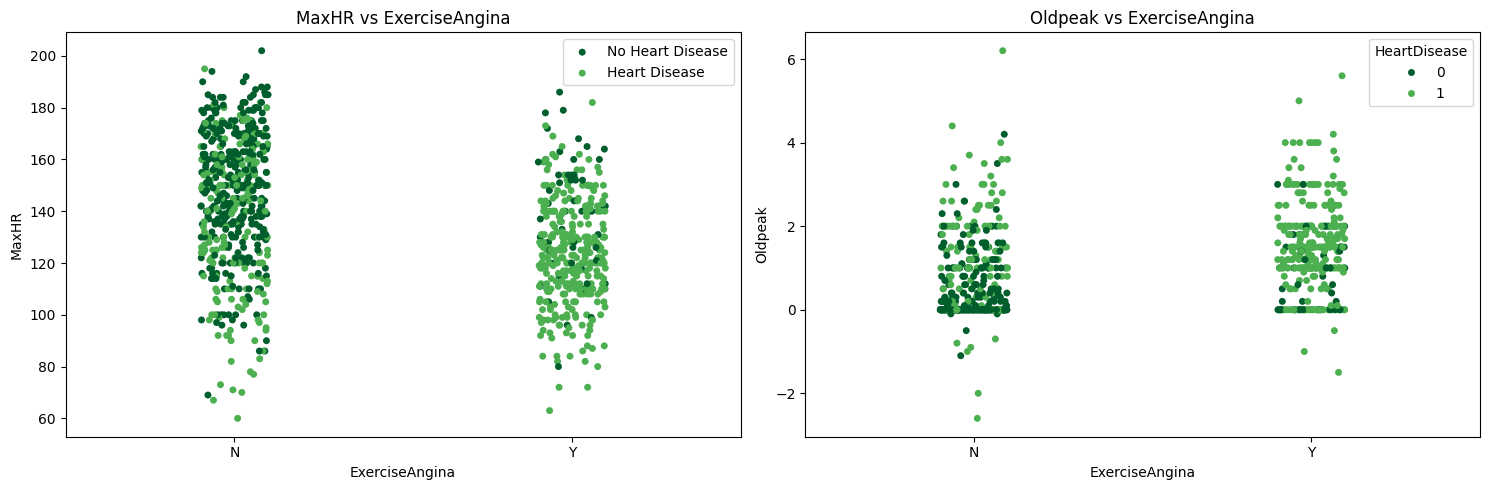

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for a, f in zip(ax, numerical_features[:3]):
    sns.stripplot(x='ExerciseAngina', y=f, data=df,
                  hue='HeartDisease', palette=colors, ax=a)
    a.set_title(f"{f} vs ExerciseAngina")

ax[0].legend(['No Heart Disease', 'Heart Disease'])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for a, f in zip(ax, numerical_features[-2:]):
    sns.stripplot(x='ExerciseAngina', y=f, data=df,
                  hue='HeartDisease', palette=colors, ax=a)
    a.set_title(f"{f} vs ExerciseAngina")

ax[0].legend(['No Heart Disease', 'Heart Disease'])
plt.tight_layout()
plt.show()


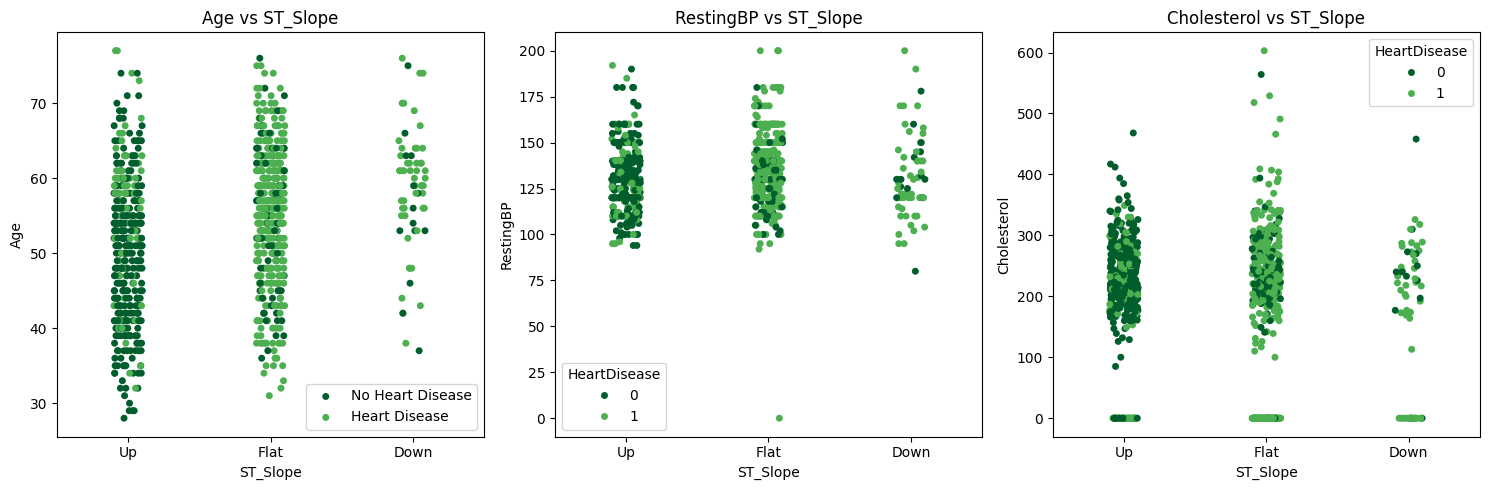

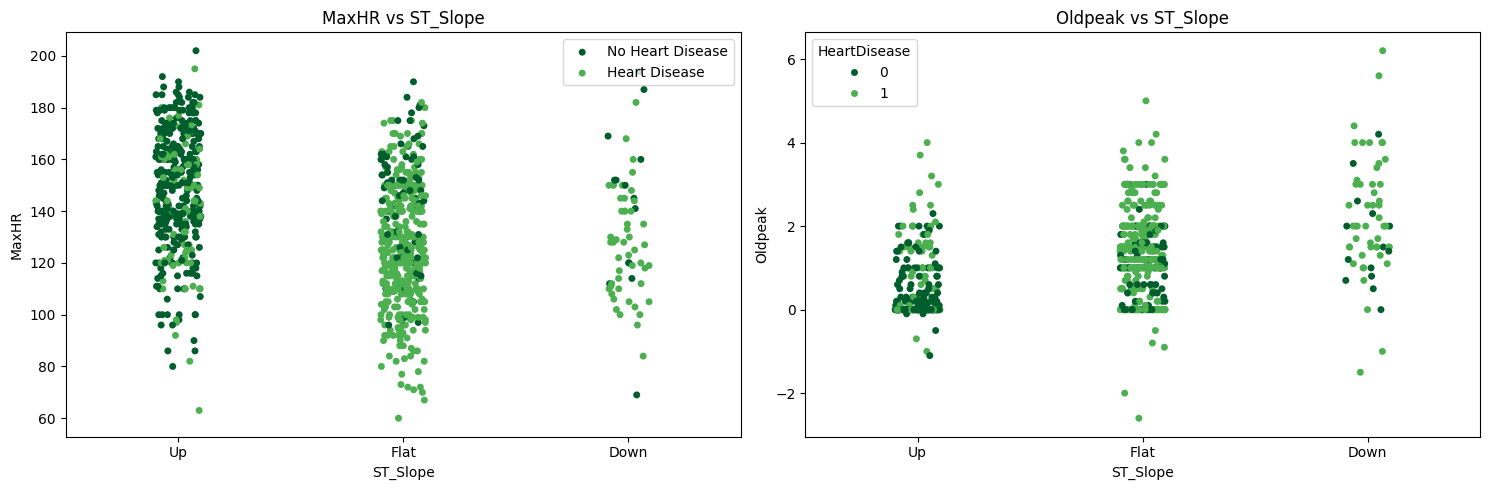

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for a, f in zip(ax, numerical_features[:3]):
    sns.stripplot(x='ST_Slope', y=f, data=df,
                  hue='HeartDisease', palette=colors, ax=a)
    a.set_title(f"{f} vs ST_Slope")

ax[0].legend(['No Heart Disease', 'Heart Disease'])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for a, f in zip(ax, numerical_features[-2:]):
    sns.stripplot(x='ST_Slope', y=f, data=df,
                  hue='HeartDisease', palette=colors, ax=a)
    a.set_title(f"{f} vs ST_Slope")

ax[0].legend(['No Heart Disease', 'Heart Disease'])
plt.tight_layout()
plt.show()


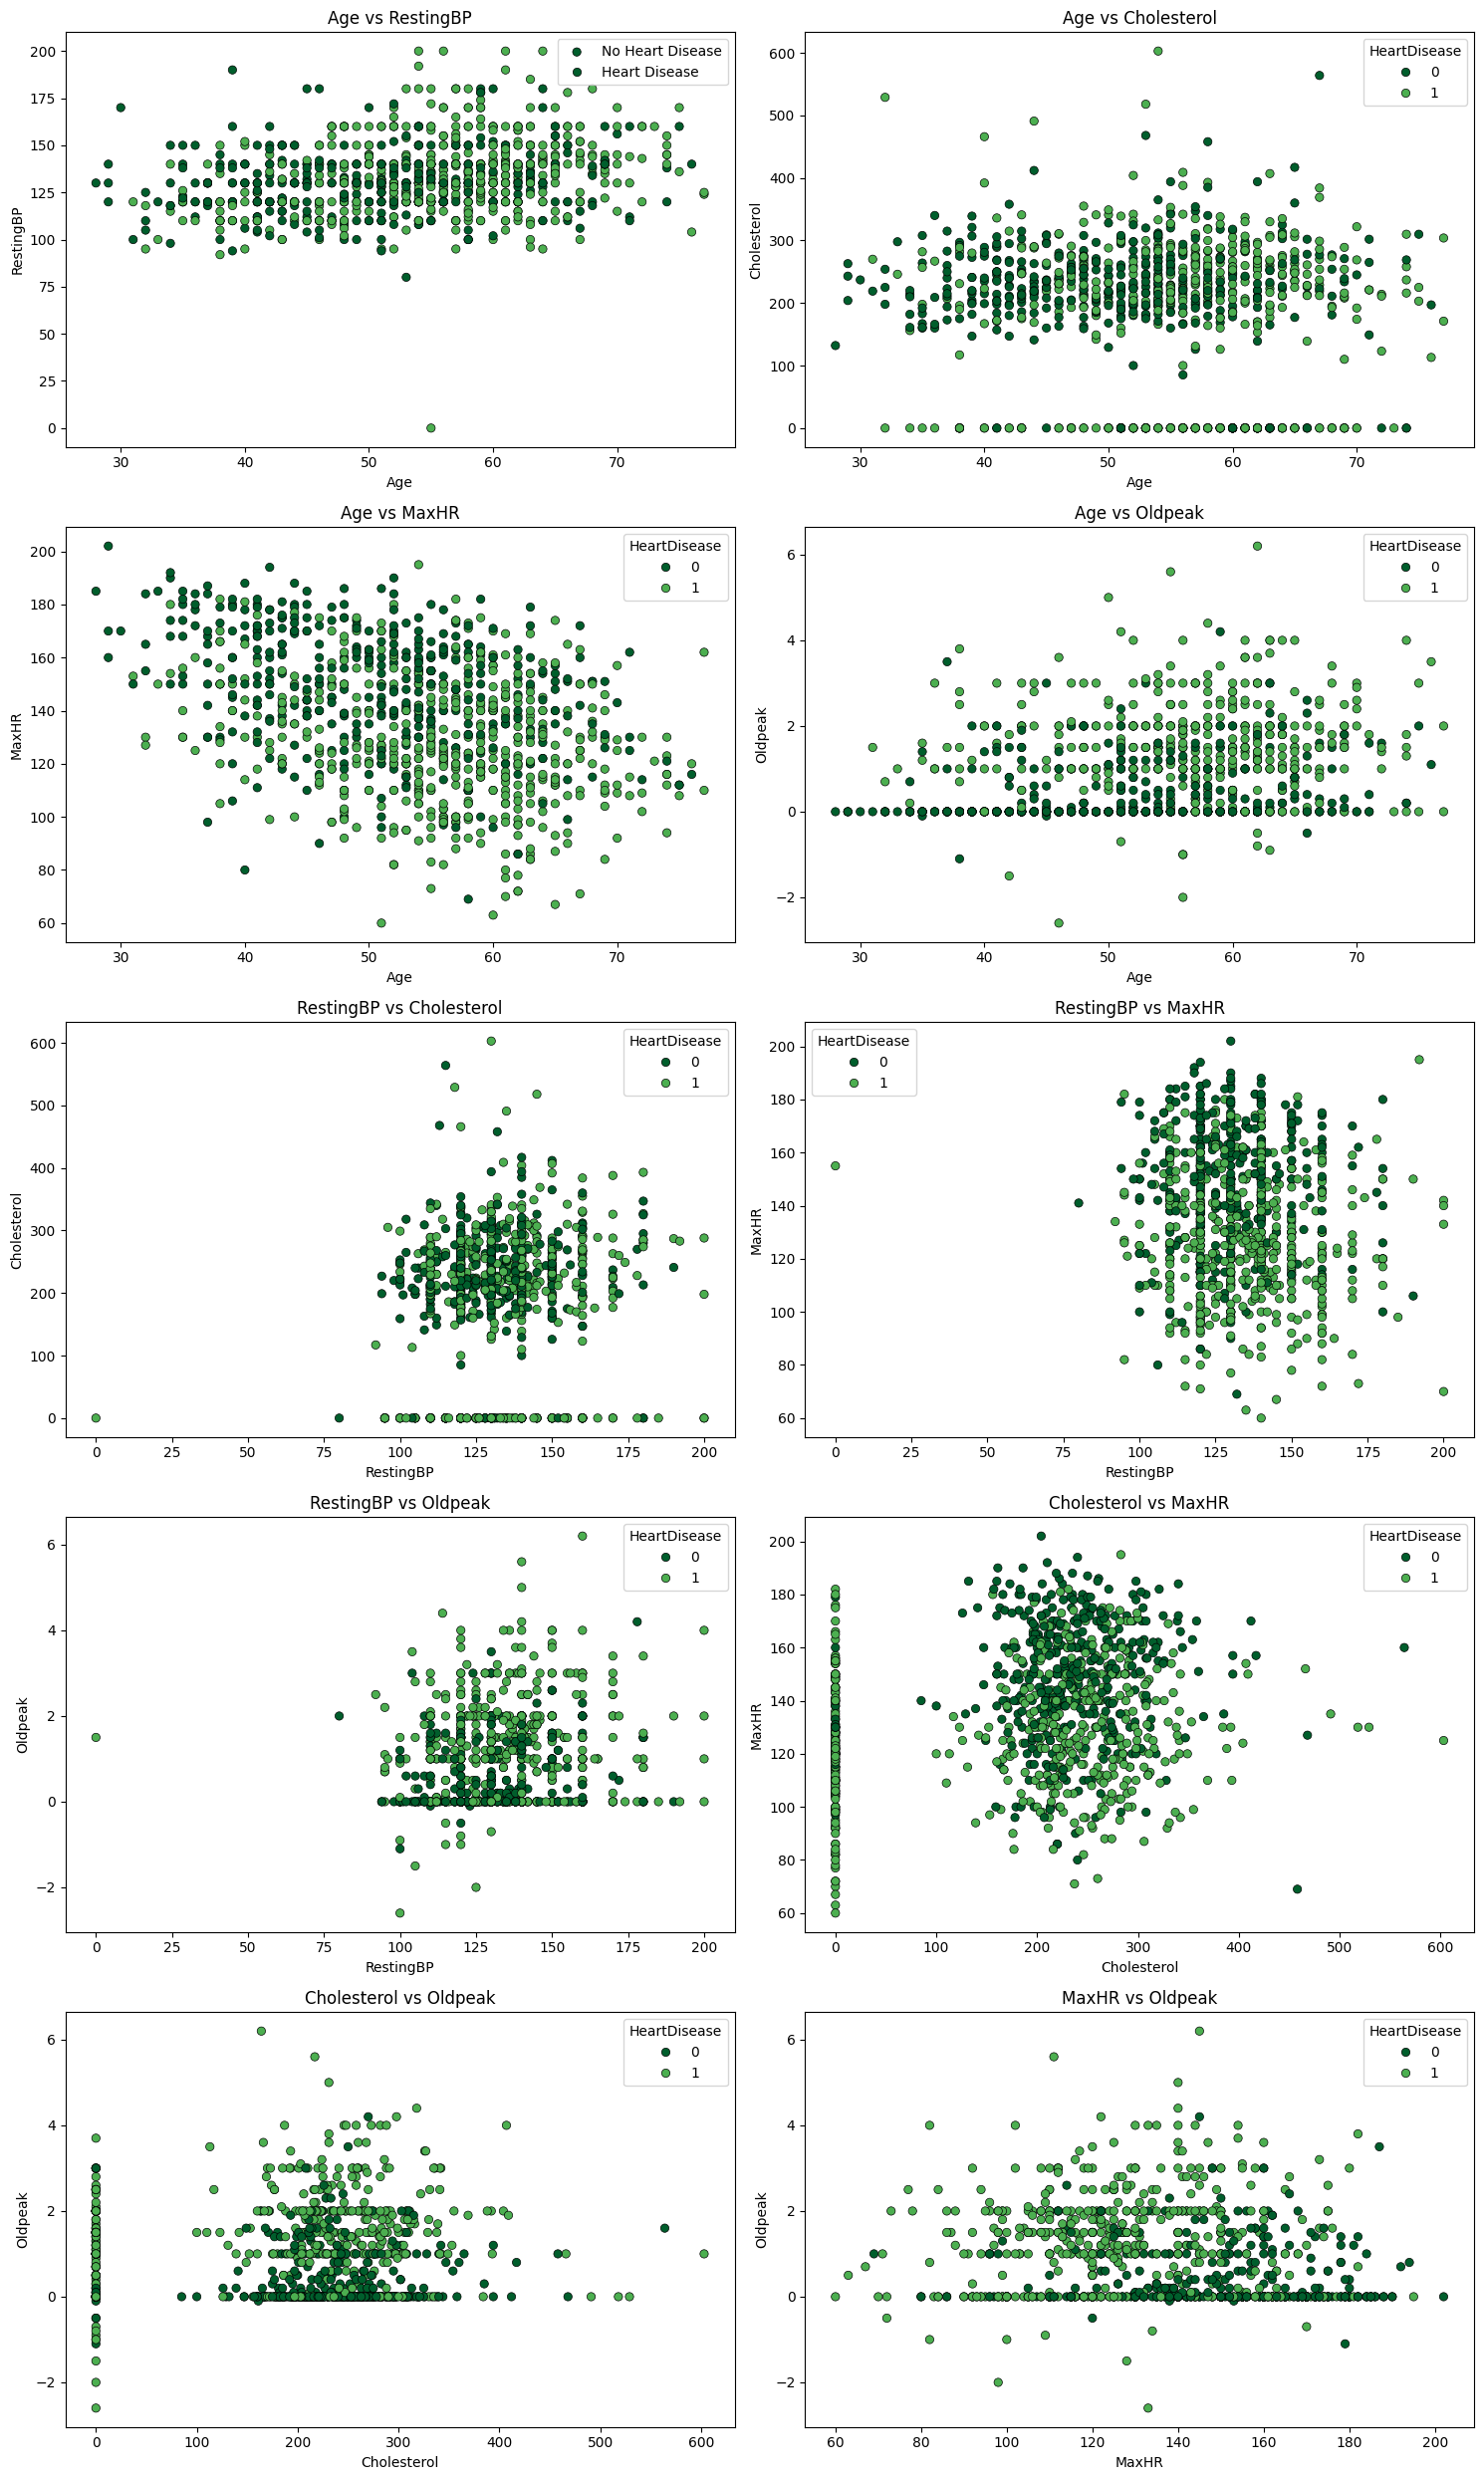

In [27]:
from itertools import combinations

pairs = list(combinations(numerical_features, 2))
fig, ax = plt.subplots(5, 2, figsize=(15, 25))
axs = ax.flatten()
for a, (x, y) in zip(axs, pairs):
    sns.scatterplot(x=x, y=y, data=df, hue='HeartDisease',
                    palette=colors, edgecolor='black', ax=a)
    a.set_title(f"{x} vs {y}")

axs[0].legend(['No Heart Disease', 'Heart Disease'])
for empty in axs[len(pairs):]:
    fig.delaxes(empty)
plt.tight_layout()
plt.show()

## Feature Engineering

In [28]:
# Create scalers
mms = MinMaxScaler()
ss = StandardScaler()
# Columns
minmax_cols = ['Oldpeak']
standard_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
# Apply MinMaxScaler
df_encoded[minmax_cols] = mms.fit_transform(df_encoded[minmax_cols])
# Apply StandardScaler
df_encoded[standard_cols] = ss.fit_transform(df_encoded[standard_cols])
df_encoded.head()

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0 -1.433140    1              1   0.410909     0.825070          0   
1 -0.478484    0              2   1.491752    -0.171961          0   
2 -1.751359    1              1  -0.129513     0.770188          0   
3 -0.584556    0              0   0.302825     0.139040          0   
4  0.051881    1              2   0.951331    -0.034755          0   

   RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0           1  1.382928               0  0.295455         2             0  
1           1  0.754157               0  0.409091         1             1  
2           2 -1.525138               0  0.295455         2             0  
3           1 -1.132156               1  0.465909         1             1  
4           1 -0.581981               0  0.295455         2             0

##### Oldpeak = Right skewed data distribution
##### 'Age', 'RestingBP', 'Cholesterol', 'MaxHR' = distributed data

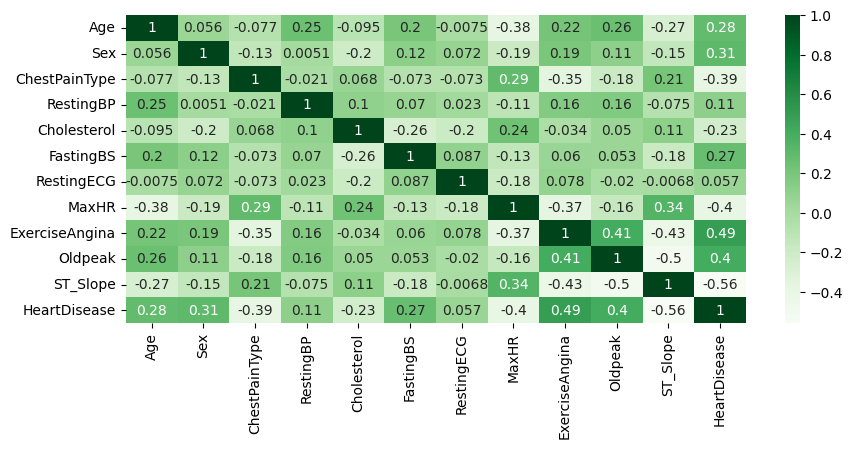

In [29]:
plt.figure(figsize = (10,4))
sns.heatmap(df_encoded.corr(),cmap = 'Greens',annot = True);

In [30]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

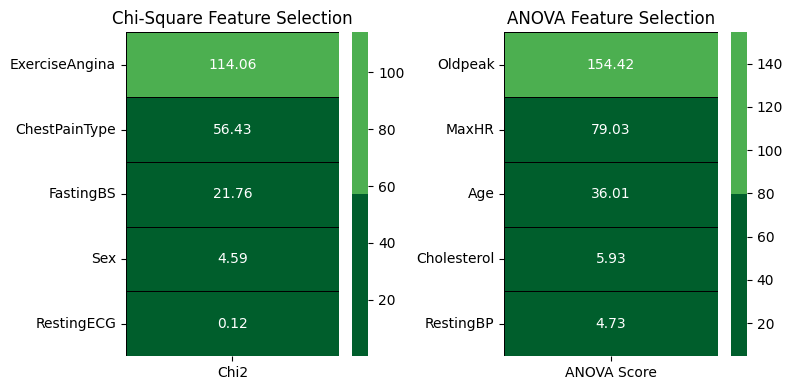

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# --- Chi-Square (categorical features) ---
chi_scores = SelectKBest(chi2, k='all').fit(
    df_encoded[categorical_features[:-1]],
    df_encoded[categorical_features[-1]]
).scores_

chi_df = pd.DataFrame(chi_scores, index=categorical_features[:-1], columns=["Chi2"])
sns.heatmap(
    chi_df.sort_values("Chi2", ascending=False),
    annot=True, cmap=colors, linewidths=.4, linecolor='black', fmt='.2f',
    ax=ax[0]
)
ax[0].set_title("Chi-Square Feature Selection")


# --- ANOVA (numerical features) ---
X = df_encoded[numerical_features]
y = df_encoded[categorical_features[-1]]

anova_scores = SelectKBest(f_classif, k='all').fit(X, y).scores_

anova_df = pd.DataFrame(anova_scores, index=numerical_features, columns=['ANOVA Score'])
sns.heatmap(
    anova_df.sort_values('ANOVA Score', ascending=False),
    annot=True, cmap=colors, linewidths=.4, linecolor='black', fmt='.2f',
    ax=ax[1]
)
ax[1].set_title("ANOVA Feature Selection")

plt.tight_layout()
plt.show()



## Machine Learning Models

In [32]:
# Splitting into full train and test
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)

# Splitting into train and test
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 42)

In [33]:
len(df_train), len(df_val), len(df_test)

(550, 184, 184)

In [34]:
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

In [35]:
y_train = df_train.HeartDisease.values
y_test = df_test.HeartDisease.values
y_val = df_val.HeartDisease.values

In [36]:
del df_train["HeartDisease"]
del df_test["HeartDisease"]
del df_val["HeartDisease"]

### One Hot Encoding

In [37]:
from sklearn.feature_extraction import DictVectorizer # for One-Hot Encoding

In [38]:
train_dicts = df_train.to_dict(orient = 'records')
One_Hot_encoder = DictVectorizer(sparse = False)
X_train = One_Hot_encoder.fit_transform(train_dicts)

In [39]:
val_dicts = df_val.to_dict(orient = 'records')
X_val = One_Hot_encoder.transform(val_dicts)

In [40]:
test_dicts = df_test.to_dict(orient = 'records')
X_test = One_Hot_encoder.transform(test_dicts)

In [41]:
One_Hot_encoder.get_feature_names_out()

array(['Age', 'ChestPainType=ASY', 'ChestPainType=ATA',
       'ChestPainType=NAP', 'ChestPainType=TA', 'Cholesterol',
       'ExerciseAngina=N', 'ExerciseAngina=Y', 'FastingBS', 'MaxHR',
       'Oldpeak', 'RestingBP', 'RestingECG=LVH', 'RestingECG=Normal',
       'RestingECG=ST', 'ST_Slope=Down', 'ST_Slope=Flat', 'ST_Slope=Up',
       'Sex=F', 'Sex=M'], dtype=object)

### Model Training & Parameter Tuning

#### Logistic Regression

In [42]:
C_values = [0.01, 0.1, 1, 2, 10, 100]
c_param_scores = []
for param in C_values:
     model = LogisticRegression(solver = 'liblinear', C = param,
                               max_iter = 1000, random_state = 42)
     model.fit(X_train, y_train)
     y_pred = model.predict(X_val)
     Accuracy_score = 100 * (y_pred == y_val).mean()
     c_param_scores += [round(Accuracy_score, 2)]
Accuracy_score = pd.Series(c_param_scores, index = C_values, name = "parameters_scores")
Accuracy_score    

0.01      87.50
0.10      89.67
1.00      88.59
2.00      88.59
10.00     88.59
100.00    88.59
Name: parameters_scores, dtype: float64

#### Decision Tree Classifier

In [43]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, 25, None]
for depth in depths: 
    dt = DecisionTreeClassifier(max_depth = depth, random_state = 42)
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_val)
    Accuracy_score = 100 * (y_pred == y_val).mean()
    print('Maximum depth: %4s -> Accuracy score: %.3f' % (depth, Accuracy_score))


Maximum depth:    1 -> Accuracy score: 86.413
Maximum depth:    2 -> Accuracy score: 86.957
Maximum depth:    3 -> Accuracy score: 90.761
Maximum depth:    4 -> Accuracy score: 91.304
Maximum depth:    5 -> Accuracy score: 91.304
Maximum depth:    6 -> Accuracy score: 90.217
Maximum depth:   10 -> Accuracy score: 85.326
Maximum depth:   15 -> Accuracy score: 85.326
Maximum depth:   20 -> Accuracy score: 85.326
Maximum depth:   25 -> Accuracy score: 85.326
Maximum depth: None -> Accuracy score: 85.326


#### Random Forrest Classifier

In [44]:
scores = []
params = np.arange(10, 201, 10)
for d in [5, 10, 15, 20, 25]:
    for n in params:
        rf = RandomForestClassifier(n_estimators = n,
                                    max_depth = d,
                                    random_state = 42,
                                    n_jobs = -1)
        rf.fit(X_train, y_train)   #Training
        y_pred = rf.predict(X_val)   #Make predictions
        Accuracy_score = 100 * (y_pred == y_val).mean()  #Accuracy score
        scores.append((d, n, Accuracy_score))   #Parameters and accuracy score storage
columns = ['max_depth', 'n_estimators', 'Accuracy_score']   #column names
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.groupby("max_depth")["Accuracy_score"].mean().round(3)


max_depth
5     91.168
10    91.413
15    91.033
20    90.815
25    90.815
Name: Accuracy_score, dtype: float64

In [45]:
max_depth = 10 #since, optimum depth is 10

In [46]:
scores = []
min_sampl = [1, 3, 5, 10, 50]
for s in min_sampl:
    for n in params:
        #initialize model
        rf = RandomForestClassifier(n_estimators = n,
                                    max_depth = 10,
                                    min_samples_leaf = s,
                                    random_state = 42,
                                    n_jobs = -1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        Accuracy_score = 100 * (y_pred == y_val).mean()  #Accuracy score
        scores.append((d, n, Accuracy_score))   #Parameters and accuracy score storage
columns = ['min_samples_leaf', 'n_estimators', 'Accuracy_score']   #column names
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.sort_values(by = ["Accuracy_score", "n_estimators"], ascending = [False, True]).head(3)

min_samples_leaf  n_estimators  Accuracy_score
2                 25            30       92.391304
3                 25            40       92.391304
43                25            40       92.391304

#### XGBoost Classifier

In [47]:
# Feature variables
features = list(One_Hot_encoder.get_feature_names_out())
# Wrap the training data into an optimized structure
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
# Wrap the validation data into an optimized structure
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

# Dataset on which we want to iterate our model
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [48]:
eta_values = [0.1, 0.3, 0.5, 0.7, 0.9]
for eta_par in eta_values:
    # Model's parameters
    xgb_params = {
        'eta': eta_par, 
        'max_depth': 15,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    
    # Model training
    model = xgb.train(xgb_params, dtrain, 
                      num_boost_round = 200)
    
    # Make predictions
    y_pred = model.predict(dval) >= 0.5
    
    # Print parameter and accuracy score
    print('eta = %.1f, max_depth = 15, min_child_weight = 1, accuracy = %.3f.' % (xgb_params['eta'], (100 * (y_pred == y_val).mean())))

eta = 0.1, max_depth = 15, min_child_weight = 1, accuracy = 89.674.
eta = 0.3, max_depth = 15, min_child_weight = 1, accuracy = 90.761.
eta = 0.5, max_depth = 15, min_child_weight = 1, accuracy = 91.848.
eta = 0.7, max_depth = 15, min_child_weight = 1, accuracy = 89.674.
eta = 0.9, max_depth = 15, min_child_weight = 1, accuracy = 88.043.


In [49]:
eta_values = [0.1, 0.3, 0.5, 0.7, 0.9]

# XgBoost fine-tuning with learning rates
for eta_par in eta_values:
    # Model's parameters
    xgb_params = {
        'eta': eta_par, 
        'max_depth': 10,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    
    # Model training
    model = xgb.train(xgb_params, dtrain, 
                      num_boost_round = 200)
    
    # Make predictions
    y_pred = model.predict(dval) >= 0.5
    
    # Print parameter and accuracy score
    print('eta = %.1f, max_depth = 10, min_child_weight = 1, accuracy = %.3f.' % (xgb_params['eta'], (100 * (y_pred == y_val).mean())))

eta = 0.1, max_depth = 10, min_child_weight = 1, accuracy = 90.761.
eta = 0.3, max_depth = 10, min_child_weight = 1, accuracy = 90.761.
eta = 0.5, max_depth = 10, min_child_weight = 1, accuracy = 91.848.
eta = 0.7, max_depth = 10, min_child_weight = 1, accuracy = 89.674.
eta = 0.9, max_depth = 10, min_child_weight = 1, accuracy = 88.587.


### Model Selection

##### The best model out of the four after training and hyperparameter tuning is Random forest with an accuracy of 92.39%.

### Model Deployment

In [60]:
def train(df_train, y_train, n_estimators = 40, max_depth = 10, min_samples_leaf = 25):
    train_dicts = df_train[categorical_features + numerical_features].to_dict(orient = 'records')
    
   
    One_Hot_encoder = DictVectorizer(sparse = False)    # Initialize One-Hot-Encoder (vectorizer)
                                                        # One-Hot-Encoder training and train data encoding
    X_train = One_Hot_encoder.fit_transform(train_dicts)

                                                        # Initialize random forest model
    rf = RandomForestClassifier(n_estimators = n_estimators,
                                max_depth = max_depth,
                                min_samples_leaf = min_samples_leaf,
                                random_state = 42,
                                n_jobs = -1)
    rf.fit(X_train, y_train)
    return One_Hot_encoder, rf
                                        # Function to make predictions with a random forest classifier
def predict(df, One_Hot_encoder, rf):
    dicts = df[categorical_features + numerical_features].to_dict(orient = 'records')

   
    X = One_Hot_encoder.transform(dicts)       # One-Hot-Encoding
                                            
    y_pred = rf.predict(X)                     # Make predictions 
    
    return y_pred
    

### Cross - Validation Training

In [61]:
n_splits = 6

In [62]:
print(f"Performing KFold Cross-Validation")
kfold = KFold(n_splits = n_splits, shuffle = True, random_state = 1)
scores = []
fold = 0
for train_idx, val_idx in kfold.split(df_full_train):             # Select train and validation data
    
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    
    y_train = df_train.HeartDisease.values                              # Select target variables
    y_val = df_val.HeartDisease.values

                                                                  # Train model
    One_Hot_encoder, rf = train(df_train, y_train)
                                                                  # Make predictions
    y_pred = predict(df_val, One_Hot_encoder, rf)

    
    Accuracy_score = round(100 * (y_pred == y_val).mean(), 2)
    scores.append(Accuracy_score)
    print(f"Accuracy on fold {fold} is {Accuracy_score} %.")
                                                                   # Increment number of fold
    fold += 1
    
print("Validation results:")
print('Accuracy_score mean = %.2f, Accuracy_score std = +- %.2f' % (np.mean(scores), np.std(scores)))

Performing KFold Cross-Validation
Accuracy on fold 0 is 84.55 %.
Accuracy on fold 1 is 89.43 %.
Accuracy on fold 2 is 79.51 %.
Accuracy on fold 3 is 83.61 %.
Accuracy on fold 4 is 86.07 %.
Accuracy on fold 5 is 85.25 %.
Validation results:
Accuracy_score mean = 84.74, Accuracy_score std = +- 2.96


In [63]:
n_estimators, max_depth, min_samples_leaf = 40, 10, 1
One_Hot_encoder, rf = train(df_full_train[categorical_features + numerical_features], df_full_train.HeartDisease,
                            n_estimators = n_estimators, max_depth = max_depth,
                            min_samples_leaf = min_samples_leaf)
y_pred = predict(df_test, One_Hot_encoder, rf)
print('Optimal model accuracy = %.2f.' % (100 * (y_pred == y_test).mean()))

Optimal model accuracy = 88.04.


##### The optimal accuracuy is not too far from the validation accuracy

### Model --> Save

In [64]:
output_file = f'rf_model_{n_estimators}_trees_depth_{max_depth}_min_samples_leaf_{min_samples_leaf}.bin'
output_file

'rf_model_40_trees_depth_10_min_samples_leaf_1.bin'

In [65]:
with open(output_file, 'wb') as f_out:
    print("Storing the model into a file")
    pickle.dump((One_Hot_encoder, rf), f_out)
    
print(f"The model is saved to {output_file}.")

Storing the model into a file
The model is saved to rf_model_40_trees_depth_10_min_samples_leaf_1.bin.


In [66]:
!ls *bin

rf_model_40_trees_depth_10_min_samples_leaf_1.bin


### Load --> Model

In [67]:
input_file = 'rf_model_40_trees_depth_10_min_samples_leaf_1.bin'
with open(input_file, 'rb') as f_in:
    One_Hot_encoder, rf = pickle.load(f_in)

rf

RandomForestClassifier(max_depth=10, n_estimators=40, n_jobs=-1,
                       random_state=42)

### Model --> Test

In [68]:
patient = {
    "Age": 46,
    "Sex": "M",                          # M or F
    "ChestPainType": "ATA",              # ATA / NAP / ASY / TA
    "RestingBP": 167,                    # integer
    "Cholesterol": 163,                  # integer
    "FastingBS": 0,                      # 0 or 1
    "RestingECG": "ST",                  # Normal / ST / LVH
    "MaxHR": 103,                        # integer
    "ExerciseAngina": "N",               # Y or N
    "Oldpeak": 1.5,                      # float
    "ST_Slope": "Down"                   # Up / Flat / Down
}

In [69]:
X_i = pd.DataFrame([patient])
y_i_pred = predict(X_i, One_Hot_encoder, rf)
print('input data:')
display(X_i)
print('output information:', y_i_pred)
if y_i_pred[0]:
    print('Define a treatment for the patient-test.')

input data:


Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   46   M           ATA        167          163          0         ST    103   

  ExerciseAngina  Oldpeak ST_Slope  
0              N      1.5     Down

output information: [1]
Define a treatment for the patient-test.
